In [1]:
# Importing necessities.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Starting variables.
ratio = 10 # This one is the controlled variable.
starting_dose = 0.5
total_gram_count = 0
price_per_gram = 2.5; sign = '£'
gap_days = 0
batch_table = pd.DataFrame({f'Day': [], f'Current Gs': [], f'Current Gs Cost ({sign})': [], f'Cumulative Gs': [], f'Cumulative Gs Cost ({sign})': [], f'Annualized Cost ({sign})': [], f'Cost Of Living ({sign})': [], f'Required Salary ({sign})': []})

In [3]:
# Salary split values.
cost_of_living        = 20000               # This might change region-to-region.
savings_requirement   = 0.375               # 37.5%
family_contribution   = 0.1                 # 10%
society_contribution  = 0.025               # 2.5%
student_load          = 0.09                # 9%
national_insurance    = 0.12                # 12%

# Taxation (UK)
personal_allowance    = [12570, 0]          # 0%   personal allowance
basic_rate            = [50271, 0.2]        # 20%  personal allowance
end_of_allowance_rate = [125140, 0.4]       # 40%, personal allowance
higher_rate           = [150000, 0.4]       # 40%, no personal allowance
additional_rate       = [150000, 0.45]      # 45%, no personal allowance

In [4]:
# Days per batch.
available_days = 365 - (ratio * 14)
days_per_batch = available_days / 5

In [5]:
# Calculating net income thresholds.
personal_allowance_net_threshold            = personal_allowance[0]
basic_rate_net_threshold                    = personal_allowance[0]     + (basic_rate[0] - personal_allowance[0]) * 0.8
end_of_allowance_rate_net_threshold         = basic_rate_net_threshold  + (end_of_allowance_rate[0] - basic_rate[0]) * 0.6
higher_rate_net_threshold                   = basic_rate[0] * 0.8       + (higher_rate[0] - basic_rate[0]) * 0.6
additional_rate_net_threshold               = basic_rate[0] * 0.8       + (higher_rate[0] - basic_rate[0]) * 0.6

# Display thresholds.
thresholds_string = f"Net Thresholds: PA < {round(personal_allowance_net_threshold)}, BR < {round(basic_rate_net_threshold)}, "
thresholds_string += f"EOA < {round(end_of_allowance_rate_net_threshold)}, HR < {round(higher_rate_net_threshold)}, "
thresholds_string += f"AR > {round(additional_rate_net_threshold)}"
print(thresholds_string)

Net Thresholds: PA < 12570, BR < 42731, EOA < 87652, HR < 100054, AR > 100054


In [6]:
def find_values(starting_dose, days_per_batch, total_gram_count):

    # Find the grams per day and the total grams, alongside with their respective costs and required salary.
    for day in range(math.trunc(days_per_batch)):
    
        # Computing the current values.
        daily_gram_count     = starting_dose    * pow(1.5 * pow(0.5, gap_days), day)
        total_gram_count     = total_gram_count + daily_gram_count
    
        # Computing the complex values.
        current_g_cost       = daily_gram_count * price_per_gram
        cumulative_g_cost    = total_gram_count * price_per_gram
        annualized_g_cost    = total_gram_count * price_per_gram * ratio 
    
        # Printing step-by-step results. (Used for testing)
        #print(f"Day: {str(day + 1)}, ToG's: {daily_gram_count:.2f} (C: {sign}{(daily_gram_count*price_per_gram):.2f}), CumG's: {total_gram_count:.2f} (C: {sign}{(total_gram_count*price_per_gram):.2f}), Annualized: {sign}{(ratio * total_gram_count*price_per_gram):.2f}")
    
        # Storing values in Dataframe.
        batch_table.loc[day, f'Day']                                           = day + 1
        batch_table.loc[day, f'Current Gs']                                    = round(daily_gram_count, 2)
        batch_table.loc[day, f'Cumulative Gs']                                 = round(total_gram_count, 2)
        batch_table.loc[day, f'Current Gs Cost ({sign})']                      = round(current_g_cost, 2)
        batch_table.loc[day, f'Cumulative Gs Cost ({sign})']                   = round(cumulative_g_cost, 2)
        batch_table.loc[day, f'Annualized Cost ({sign})']                      = round(annualized_g_cost, 2)
    
        ## Compute salary requirements.
        taxed_income       = 2 * (annualized_g_cost + cost_of_living); # 2 is used an approximation because I can't be bothered to do the dynamic percent breakdown.
        batch_table.loc[day, f'Cost Of Living ({sign})']                       = round(taxed_income, 2)
   
        # Find untaxed income (reverse income tax calculation)
        if round(taxed_income)    < round(personal_allowance_net_threshold):
            untaxed_income = taxed_income
            batch_table.loc[day, f'Income Bracket']                            = 1
    
        if round(taxed_income)    > round(personal_allowance_net_threshold)    and round(taxed_income) < round(basic_rate_net_threshold):
            untaxed_income = ((taxed_income - personal_allowance[0]) / 0.8)    + personal_allowance[0]
            batch_table.loc[day, f'Income Bracket']                            = 2
    
        if round(taxed_income)    > round(basic_rate_net_threshold)            and round(taxed_income) < round(end_of_allowance_rate_net_threshold):
            untaxed_income = (taxed_income - personal_allowance[0]             - ((basic_rate[0] - personal_allowance[0]) * 0.8)) / 0.6 + basic_rate[0]
            batch_table.loc[day, f'Income Bracket']                            = 3

        if round(taxed_income)    > round(end_of_allowance_rate_net_threshold) and round(taxed_income) < round(higher_rate_net_threshold):
            untaxed_income = (taxed_income - basic_rate[0] * 0.8)    / 0.6     + basic_rate[0]
            batch_table.loc[day, f'Income Bracket']                            = 4
    
        if round(taxed_income)    > round(additional_rate_net_threshold): 
            untaxed_income = (taxed_income - (basic_rate[0] * 0.8)             - (additional_rate[0] - basic_rate[0])     * 0.6) / 0.6 + additional_rate[0]
            batch_table.loc[day, f'Income Bracket']                            = 5
    
        # Account for NI and Student Loans. These are hard-coded to be somewhat wrong but are good for approximations.
        if untaxed_income < 400000:
            student_loan_tax_addition            = untaxed_income * student_load                                          # Account for student loans.
            national_insurance_tax_addition      = untaxed_income * national_insurance                                    # Account for national insurance tax.
            untaxed_income                       += student_loan_tax_addition + national_insurance_tax_addition
        else:
            national_insurance_tax_addition      = untaxed_income * national_insurance                                    # Account for national insurance tax.
            untaxed_income                       += national_insurance_tax_addition
    
        # Store salary in Dataframe.
        batch_table.loc[day, f'Required Salary ({sign})']                      = round(untaxed_income, 2)

find_values(starting_dose, days_per_batch, total_gram_count)

C:\Users\Quachy\AppData\Local\Temp\ipykernel_11008\1874988634.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  display(batch_table.style.hide_index())


Day,Current Gs,Current Gs Cost (£),Cumulative Gs,Cumulative Gs Cost (£),Annualized Cost (£),Cost Of Living (£),Required Salary (£),Income Bracket
1.000000,0.500000,1.250000,0.500000,1.250000,12.500000,40025.000000,56735.390000,2.000000
2.000000,0.750000,1.880000,1.250000,3.120000,31.250000,40062.500000,56792.110000,2.000000
3.000000,1.120000,2.810000,2.380000,5.940000,59.380000,40118.750000,56877.180000,2.000000
4.000000,1.690000,4.220000,4.060000,10.160000,101.560000,40203.120000,57004.800000,2.000000
5.000000,2.530000,6.330000,6.590000,16.480000,164.840000,40329.690000,57196.230000,2.000000
6.000000,3.800000,9.490000,10.390000,25.980000,259.770000,40519.530000,57483.370000,2.000000
7.000000,5.700000,14.240000,16.090000,40.210000,402.150000,40804.300000,57914.070000,2.000000
8.000000,8.540000,21.360000,24.630000,61.570000,615.720000,41231.450000,58560.140000,2.000000
9.000000,12.810000,32.040000,37.440000,93.610000,936.080000,41872.170000,59529.230000,2.000000
10.000000,19.220000,48.050000,56.670000,141.660000,1416.630000,42833.250000,61034.520000,3.000000


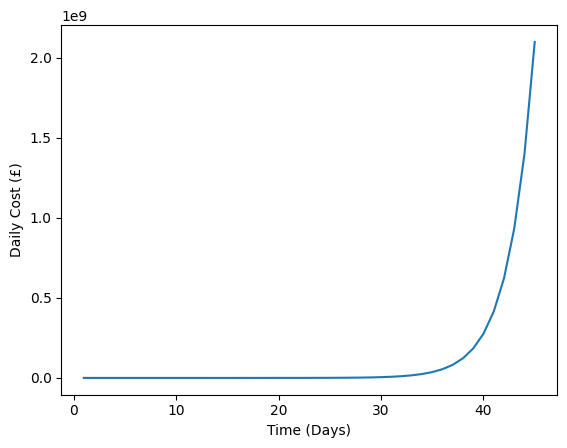

In [7]:
# Display results in Dataframe:
display(batch_table.style.hide_index())

# Graph costs.
plt.plot(batch_table['Day'], batch_table[f'Annualized Cost ({sign})']); plt.xlabel('Time (Days)'); plt.ylabel(f'Daily Cost ({sign})'); plt.show()

In [8]:
# Build dataframe that computes iteratively through values. (Look behind)
# Use this to create graphs.

# 